In [1]:
import numpy as np
from sklearn.linear_model import LinearRegression
import xarray as xr
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('default')
sns.set_palette("colorblind")
from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.weight'] = 'light'
rcParams['mathtext.fontset'] = 'cm'
rcParams['mathtext.rm'] = 'serif'
mpl.rcParams["figure.dpi"] = 500
import cartopy.crs as ccrs
import cartopy as ct
import matplotlib.colors as c
import regionmask
import cmasher as cmr
import scipy
from cartopy.util import add_cyclic_point
mpl.rcParams['hatch.linewidth'] = 0.5
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from geocat.comp import eofunc_eofs, eofunc_pcs
from datetime import datetime
import warnings
from matplotlib.patches import Rectangle
import pdo_functions
import importlib
importlib.reload(pdo_functions)
import random
import numba
import statsmodels.api as sm
import glob
import pandas as pd
from sklearn.metrics import r2_score

In [10]:
# Open datasets
cape = xr.open_mfdataset('/hurrell-scratch2/ivyglade/pdo/wrf_cape/era5_daily_max_mucape_*s.nc', combine='nested', concat_dim='year')['__xarray_dataarray_variable__']
s06 = xr.open_mfdataset('/hurrell-scratch2/ivyglade/pdo/ERA5_S06/era5_s06_*s.nc', combine='nested', concat_dim='time')['__xarray_dataarray_variable__']

In [11]:
# Subset the central US
cape_east = cape.sel(longitude=slice(pdo_functions.convert_longitudes(-101), pdo_functions.convert_longitudes(-83))).sel(latitude=slice(47, 31))
s06_east  = s06.sel(longitude=slice(pdo_functions.convert_longitudes(-101), pdo_functions.convert_longitudes(-83))).sel(latitude=slice(47, 31))

In [17]:
# Select MAM only
cape_east_mam = cape_east.sel(date=cape_east.date.where(
                                   cape_east.date.str.startswith('03-') |
                                   cape_east.date.str.startswith('04-') |
                                   cape_east.date.str.startswith('05-'), 
                                   drop=True)).load()

s06_east_mam = s06_east.sel(time=s06_east.time.dt.month.isin([3, 4, 5])).load()

In [21]:
# Flatten to have a single time dimension - CAPE
cape_east_mam_stack = cape_east_mam.stack(time=('year', 'date'))

# Convert time to datetime
year = cape_east_mam_stack['time'].get_index('time').get_level_values('year')
date = cape_east_mam_stack['time'].get_index('time').get_level_values('date')

datetime = pd.to_datetime(year.astype(str) + '-' + date.astype(str))

cape_east_mam_stack = cape_east_mam_stack.assign_coords(time=datetime).transpose('time', 'latitude', 'longitude')

/tmp/ipykernel_181743/1206080369.py:10: FutureWarning: updating coordinate 'time' with a PandasMultiIndex would leave the multi-index level coordinates ['year', 'date'] in an inconsistent state. This will raise an error in the future. Use `.drop_vars(['time', 'year', 'date'])` before assigning new coordinate values.
  cape_east_mam_stack = cape_east_mam_stack.assign_coords(time=datetime).transpose('time', 'latitude', 'longitude')


In [31]:
# Take monthly means
cape_east_mam_mean = cape_east_mam_stack.resample(time='ME').mean().dropna(dim='time')
s06_east_mam_mean = s06_east_mam.resample(time='ME').mean().dropna(dim='time')

# Remove seasonal cycle
cape_east_mam_no = cape_east_mam_mean.groupby('time.month') - cape_east_mam_mean.groupby('time.month').mean()
s06_east_mam_no = s06_east_mam_mean.groupby('time.month') - s06_east_mam_mean.groupby('time.month').mean()

# Detrend
cape_east_mam_anoms = pdo_functions.detrend_dim(cape_east_mam_no, 'time', 2)
s06_east_mam_anoms = pdo_functions.detrend_dim(s06_east_mam_no, 'time', 2)

In [33]:
# Open SST data and compute the PDO and Nino3.4
sst = xr.open_dataset('/hurrell-scratch2/ivyglade/pdo/HadISST_sst.nc')['sst']

pdo = pdo_functions.pdo_from_hadisst(sst, 1980, 2010)

nino_34 = pdo_functions.calc_nino_34_timeseries(sst, False, 1980, 2010)

In [34]:
# Standardize Nino3.4
nino_34_std = (nino_34 - nino_34.mean()) / nino_34.std()

In [36]:
# Convert pdo to xarray
pdo_xr = xr.DataArray(pdo, coords={'time':nino_34['time']}, dims=['time'])

# Subset only 1940-2024
pdo_1940_2024 = pdo_xr.sel(time=pdo_xr.time.dt.year.isin(np.arange(1940, 2025, 1)))
nino_34_1940_2024 = nino_34_std.sel(time=nino_34_std.time.dt.year.isin(np.arange(1940, 2025, 1)))

# only MAM and take seasonal averages
pdo_1940_2024_mam = pdo_1940_2024.sel(time=pdo_1940_2024.time.dt.month.isin([3, 4, 5]))#.resample(time='1Y').mean()
nino_34_1940_2024_mam = nino_34_1940_2024.sel(time=nino_34_1940_2024.time.dt.month.isin([3, 4, 5]))#.resample(time='1Y').mean()

# aligning time arrays with that of CAPE
pdo_1940_2024_mam['time'] = cape_east_mam_anoms['time']
nino_34_1940_2024_mam['time'] = cape_east_mam_anoms['time']

s06_east_mam_anoms['time'] = cape_east_mam_anoms['time']

In [138]:
# Composite
cape_pos_pdo = xr.where(pdo_1940_2024_mam > 0, cape_east_mam_mean, np.nan).dropna(dim='time')
s06_pos_pdo = xr.where(pdo_1940_2024_mam > 0, s06_east_mam_mean, np.nan).dropna(dim='time')

In [126]:
cape_string = cape_east_mam_mean.stack(idx=('time', 'latitude', 'longitude'))
s06_string = s06_east_mam_mean.stack(idx=('time', 'latitude', 'longitude'))

cape_string_nonan = cape_string.dropna(dim='idx')

s06_string_cape = s06_string.where(~cape_string.isnull())

s06_string_nonan = s06_string_cape.dropna(dim='idx')

In [136]:
# Custom bin edges
x_bins = np.linspace(0, 1500, 16)     # 20 bins between -4 and 4
y_bins = np.linspace(0, 30, 16)  

(array([[9.8100e+02, 2.2550e+03, 3.4930e+03, 7.9460e+03, 1.2031e+04,
         1.6501e+04, 1.9252e+04, 2.1958e+04, 2.7911e+04, 3.5677e+04,
         3.5342e+04, 3.3158e+04, 3.1465e+04, 2.6177e+04, 2.3375e+04,
         1.9098e+04, 1.3484e+04, 1.0376e+04, 8.6660e+03, 5.4720e+03],
        [7.3400e+02, 2.4850e+03, 3.6800e+03, 4.3360e+03, 6.3050e+03,
         1.0373e+04, 1.4156e+04, 1.3699e+04, 1.6521e+04, 2.1597e+04,
         1.9714e+04, 1.8320e+04, 1.6618e+04, 1.4530e+04, 1.1714e+04,
         9.3280e+03, 6.2820e+03, 5.1760e+03, 4.5320e+03, 3.8020e+03],
        [9.6200e+02, 2.7570e+03, 3.7020e+03, 3.8530e+03, 6.1060e+03,
         9.0140e+03, 9.4120e+03, 1.0193e+04, 1.2318e+04, 1.2911e+04,
         1.4358e+04, 1.3829e+04, 1.1135e+04, 9.2350e+03, 6.5770e+03,
         5.3760e+03, 4.3260e+03, 3.5240e+03, 2.3450e+03, 1.4850e+03],
        [1.0130e+03, 2.5390e+03, 3.9650e+03, 5.2060e+03, 6.8380e+03,
         7.4480e+03, 7.6770e+03, 8.0520e+03, 9.0120e+03, 9.7280e+03,
         9.6780e+03, 8.8250e+03

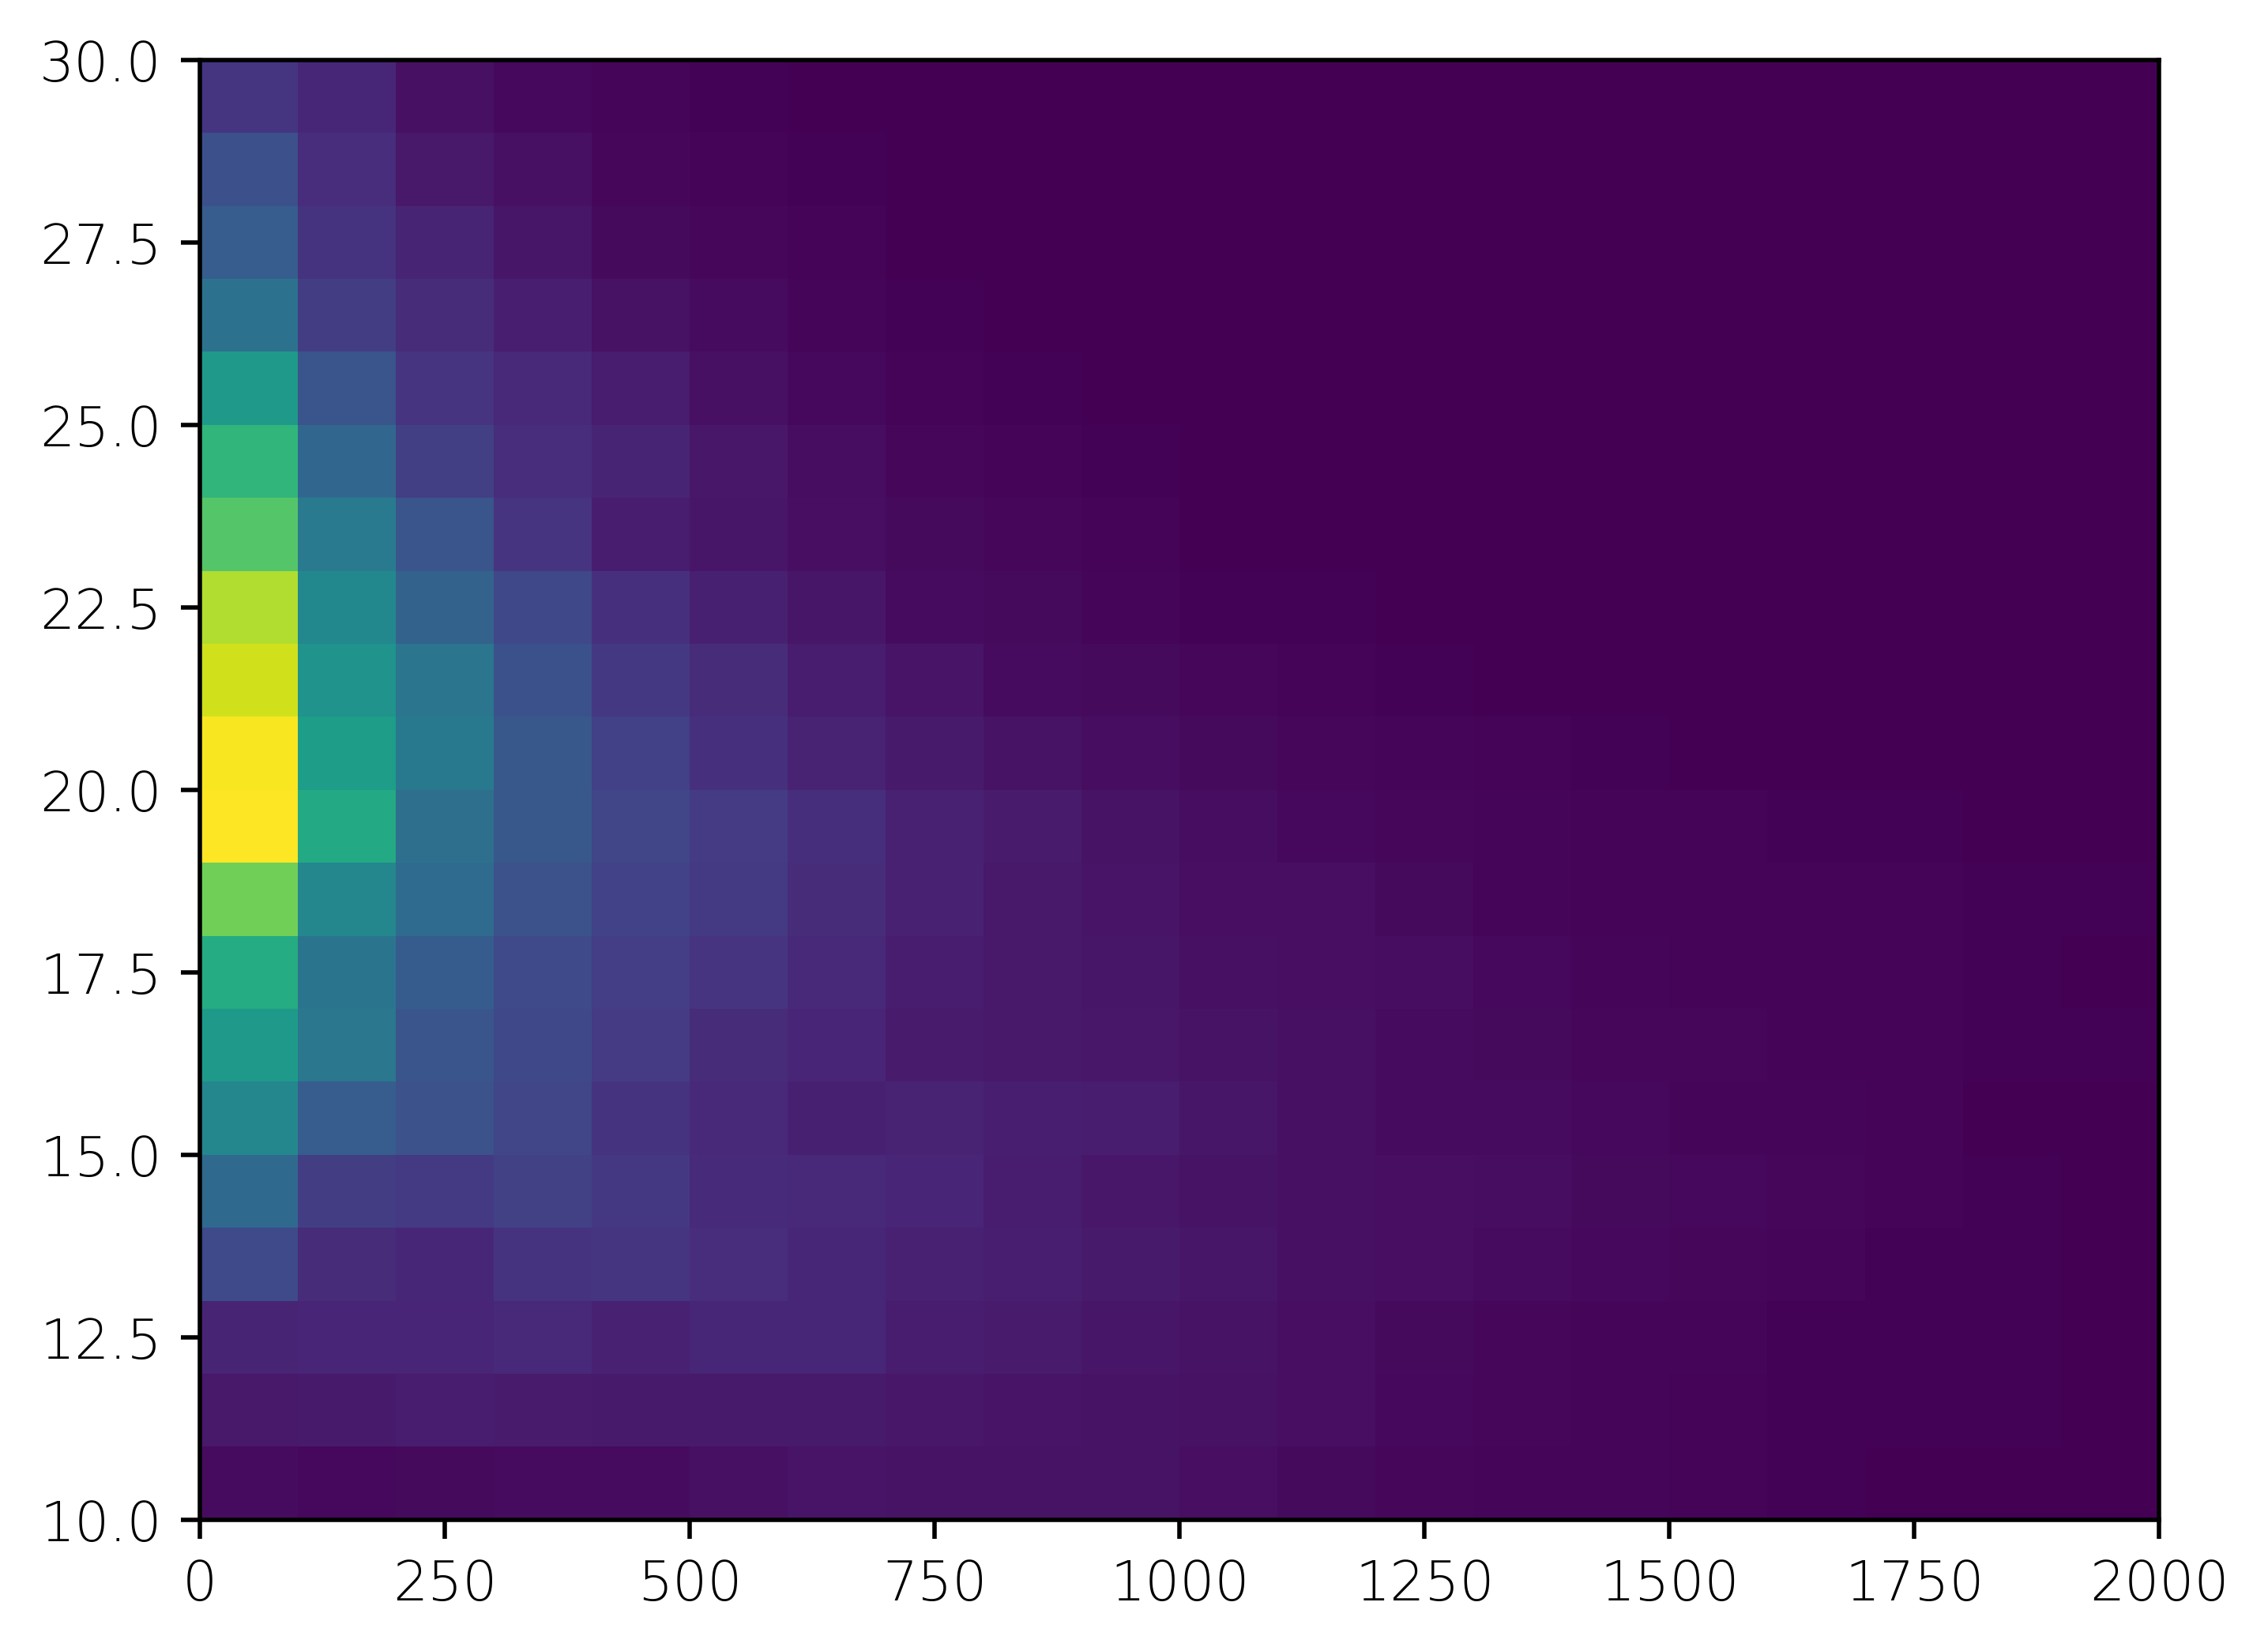

In [137]:
fig, ax = plt.subplots()

# Custom bin edges
x_bins = np.linspace(0, 2000, 21)     
y_bins = np.linspace(10, 30, 21)  

ax.hist2d(cape_string_nonan, s06_string_nonan, bins=[x_bins, y_bins])